In [22]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt


@dataclass
class Params:
    """Container for physical, initial-condition, and numerical parameters.

    Attributes
    ----------
    E : float
        Young's modulus of the arresting cable.
    rho : float
        Density of the arresting cable.
    A : float
        Cross-sectional area of the cable.
    L : float
        Total cable length.
    N_mech : float
        Mechanical advantage between carriage displacement and cable end motion.
    m_f : float
        Aircraft mass.
    m_c : float
        Carriage mass.
    c_h : float
        Hydraulic damping coefficient.
    k_h : float
        Hydraulic stiffness.
    V0 : float
        Initial aircraft touchdown speed.
    nx : int
        Number of spatial intervals in the cable discretization.
    dt : float
        Time step size.
    t_final : float
        Final simulation time.
    """
    E: float
    rho: float
    A: float
    L: float
    N_mech: float
    m_f: float
    m_c: float
    c_h: float
    k_h: float
    V0: float
    nx: int
    dt: float
    t_final: float


def default_params() -> Params:
    """Return a default set of parameters for the arresting-gear simulation.

    Returns
    -------
    Params
        Parameter object populated with nominal values.
    """
    return Params(
        E=1.0e9, rho=7800.0, A=2.0e-4, L=60.0,
        N_mech=18.0, m_f=25000.0, m_c=277.8,
        c_h=2.0e6, k_h=1.0e8,
        V0=65.0,
        nx=400, dt=1.0e-4, t_final=10.0
    )


def make_mesh(L: float, nx: int):
    """Return spatial grid and grid spacing for the cable.

    Parameters
    ----------
    L : float
        Cable length.
    nx : int
        Number of spatial subintervals.

    Returns
    -------
    x : (nx+1,) ndarray
        Spatial grid including both boundaries.
    dx : float
        Spatial step size.
    """
    x = np.linspace(0.0, L, nx + 1)
    dx = x[1] - x[0]
    return x, dx


def unpack_state(z, nx):
    """Unpack the global state vector into physical components.

    Parameters
    ----------
    z : ndarray
        Global state vector.
    nx : int
        Number of spatial intervals.

    Returns
    -------
    u_int : (nx-1,) ndarray
        Interior cable displacements.
    v_int : (nx-1,) ndarray
        Interior cable velocities.
    x_f : float
        Aircraft position.
    v_f : float
        Aircraft velocity.
    y : float
        Carriage displacement.
    v_y : float
        Carriage velocity.
    """
    n_int = nx - 1
    u_int = z[0:n_int]
    v_int = z[n_int:2*n_int]
    x_f, v_f, y, v_y = z[2*n_int:2*n_int+4]
    return u_int, v_int, x_f, v_f, y, v_y


def pack_state(u_int, v_int, x_f, v_f, y, v_y):
    """Pack physical state components into a single state vector.

    Parameters
    ----------
    u_int : ndarray
        Interior cable displacements.
    v_int : ndarray
        Interior cable velocities.
    x_f : float
        Aircraft position.
    v_f : float
        Aircraft velocity.
    y : float
        Carriage displacement.
    v_y : float
        Carriage velocity.

    Returns
    -------
    z : ndarray
        Global state vector.
    """
    return np.concatenate([u_int, v_int, np.array([x_f, v_f, y, v_y])])


def build_full_u(u_int, x_f, y, N_mech):
    """Construct full cable displacement including boundary values.

    Parameters
    ----------
    u_int : (nx-1,) ndarray
        Interior cable displacements.
    x_f : float
        Aircraft displacement (right boundary).
    y : float
        Carriage displacement (left boundary).
    N_mech : float
        Mechanical advantage.

    Returns
    -------
    u_full : (nx+1,) ndarray
        Full nodal displacement vector.
    """
    u0 = N_mech * y
    uN = x_f
    return np.concatenate([[u0], u_int, [uN]])


def boundary_slopes(u_full, dx):
    """Compute cable slope at both boundaries using one-sided differences.

    Parameters
    ----------
    u_full : ndarray
        Full nodal displacement vector.
    dx : float
        Spatial step size.

    Returns
    -------
    ux0 : float
        Displacement slope at x = 0.
    uxL : float
        Displacement slope at x = L.
    """
    ux0 = (-3*u_full[0] + 4*u_full[1] - u_full[2]) / (2*dx)
    uxL = ( 3*u_full[-1] - 4*u_full[-2] + u_full[-3]) / (2*dx)
    return ux0, uxL


def interior_accel(u_full, c2, dx):
    """Compute interior cable accelerations from the wave equation.

    Parameters
    ----------
    u_full : ndarray
        Full nodal displacement vector.
    c2 : float
        Square of wave speed.
    dx : float
        Spatial step size.

    Returns
    -------
    a_int : (nx-1,) ndarray
        Interior cable accelerations.
    """
    u_im1 = u_full[0:-2]
    u_i   = u_full[1:-1]
    u_ip1 = u_full[2:]
    uxx = (u_ip1 - 2*u_i + u_im1) / (dx*dx)
    return c2 * uxx


def rhs(t, z, p, dx):
    """Evaluate the right-hand side of the coupled PDE–ODE system.

    Parameters
    ----------
    t : float
        Current time.
    z : ndarray
        Current state vector.
    p : Params
        Simulation parameters.
    dx : float
        Spatial step size.

    Returns
    -------
    dzdt : ndarray
        Time derivative of the state vector.
    """
    u_int, v_int, x_f, v_f, y, v_y = unpack_state(z, p.nx)

    u_full = build_full_u(u_int, x_f, y, p.N_mech)

    c2 = p.E / p.rho
    a_int = interior_accel(u_full, c2, dx)

    ux0, uxL = boundary_slopes(u_full, dx)
    T0 = p.E * p.A * ux0
    TL = p.E * p.A * uxL

    a_f = (-2.0 * TL) / p.m_f
    a_y = (p.N_mech * T0 - p.c_h * v_y - p.k_h * y) / p.m_c

    return pack_state(v_int, a_int, v_f, a_f, v_y, a_y)


def rk4_step(f, t, z, dt, *args):
    """Advance the state one time step using RK4.

    Parameters
    ----------
    f : callable
        Right-hand-side function.
    t : float
        Current time.
    z : ndarray
        Current state.
    dt : float
        Time step size.

    Returns
    -------
    z_next : ndarray
        State after one RK4 step.
    """
    k1 = f(t, z, *args)
    k2 = f(t + 0.5*dt, z + 0.5*dt*k1, *args)
    k3 = f(t + 0.5*dt, z + 0.5*dt*k2, *args)
    k4 = f(t + dt, z + dt*k3, *args)
    return z + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)


def integrate(f, z0, t0, tf, dt, p, dx):
    """Integrate the coupled PDE–ODE system forward in time using RK4.

    The integration terminates early when the aircraft velocity reaches
    zero, indicating a completed arrestment. Linear interpolation is used
    to stop exactly at v_f = 0.

    Parameters
    ----------
    f : callable
        Right-hand-side function defining the time derivatives of the state.
    z0 : ndarray
        Initial state vector.
    t0 : float
        Initial simulation time.
    tf : float
        Maximum final simulation time.
    dt : float
        Time step size.
    p : Params
        Simulation parameter object.
    dx : float
        Spatial step size.

    Returns
    -------
    ts : ndarray
        Array of time values.
    zs : ndarray
        Array of state vectors corresponding to each time value.
    """
    nsteps = int(np.ceil((tf - t0)/dt))
    t = t0
    z = z0.copy()

    n_int = p.nx - 1
    vf_idx = 2*n_int + 1

    ts = [t]
    zs = [z.copy()]

    for _ in range(nsteps):
        z_prev = z.copy()
        t_prev = t
        v_prev = z_prev[vf_idx]

        z = rk4_step(f, t, z, dt, p, dx)
        t = t + dt
        v_new = z[vf_idx]

        if v_new <= 0.0:
            if v_new == 0.0 or v_prev == v_new:
                ts.append(t)
                zs.append(z.copy())
                break

            alpha = (0.0 - v_prev) / (v_new - v_prev)
            t_hit = t_prev + alpha * (t - t_prev)
            z_hit = z_prev + alpha * (z - z_prev)
            z_hit[vf_idx] = 0.0

            ts.append(t_hit)
            zs.append(z_hit.copy())
            break

        ts.append(t)
        zs.append(z.copy())

    return np.array(ts), np.array(zs)


def initial_state(p: Params):
    """Construct the initial state vector for the simulation.

    Parameters
    ----------
    p : Params
        Simulation parameter object.

    Returns
    -------
    z0 : ndarray
        Initial state vector with zero cable displacement, zero carriage
        motion, and prescribed initial aircraft velocity.
    """
    n_int = p.nx - 1
    u_int0 = np.zeros(n_int)
    v_int0 = np.zeros(n_int)
    x_f0, v_f0 = 0.0, p.V0
    y0, v_y0 = 0.0, 0.0
    return pack_state(u_int0, v_int0, x_f0, v_f0, y0, v_y0)


def run(p: Params):
    """Run the full arresting-gear simulation.

    Parameters
    ----------
    p : Params
        Simulation parameter object.

    Returns
    -------
    x : ndarray
        Spatial grid for the cable.
    ts : ndarray
        Time history.
    zs : ndarray
        State history over time.
    """
    x, dx = make_mesh(p.L, p.nx)
    z0 = initial_state(p)
    ts, zs = integrate(rhs, z0, 0.0, p.t_final, p.dt, p, dx)
    return x, ts, zs


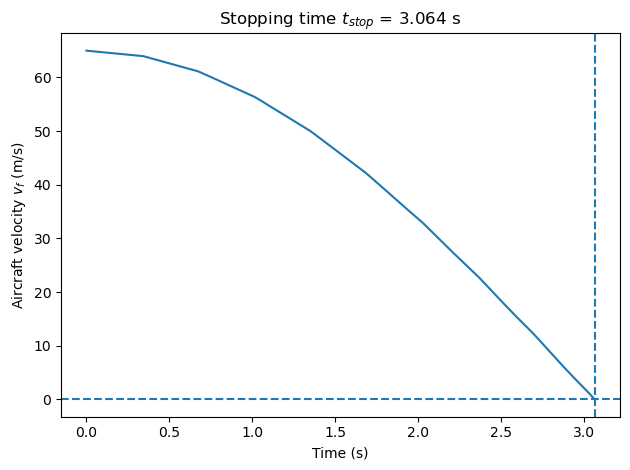

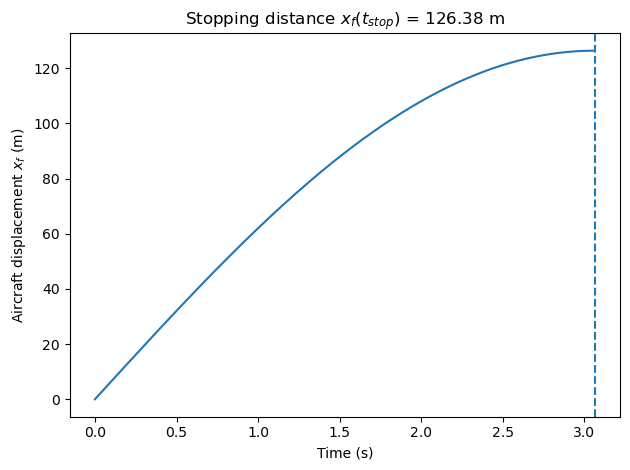

In [23]:



def _extract_aircraft_signals(p, ts, zs):
    """Return aircraft displacement, velocity, and time arrays.

    Parameters
    ----------
    p : Params
        Simulation parameter object.
    ts : ndarray
        Time history.
    zs : ndarray
        State history.

    Returns
    -------
    x_f : ndarray
        Aircraft displacement history.
    v_f : ndarray
        Aircraft velocity history.
    t_stop : float
        Stopping time (final time in ts).
    x_stop : float
        Stopping distance (final x_f).
    """
    n_int = p.nx - 1
    x_f = zs[:, 2*n_int + 0]
    v_f = zs[:, 2*n_int + 1]
    t_stop = ts[-1]
    x_stop = x_f[-1]
    return x_f, v_f, t_stop, x_stop


def _compute_TL_and_af(p, dx, zs):
    """Compute right-end tension TL and aircraft acceleration a_f over time.

    Parameters
    ----------
    p : Params
        Simulation parameter object.
    dx : float
        Spatial step size.
    zs : ndarray
        State history.

    Returns
    -------
    TL : ndarray
        Right-end cable tension history.
    a_f : ndarray
        Aircraft acceleration history (model equation).
    """
    TL = np.empty(len(zs))
    a_f = np.empty(len(zs))

    for k in range(len(zs)):
        u_int, v_int, x_f, v_f, y, v_y = unpack_state(zs[k], p.nx)
        u_full = build_full_u(u_int, x_f, y, p.N_mech)
        _, uxL = boundary_slopes(u_full, dx)
        TL_k = p.E * p.A * uxL
        TL[k] = TL_k
        a_f[k] = (-2.0 * TL_k) / p.m_f

    return TL, a_f


def plot_q1_stopping_performance(p, ts, zs):
    """Q1 plot: stopping time and stopping distance from simulation histories.

    Produces two figures:
    1) v_f(t) with stop time marked
    2) x_f(t) with stop time marked

    Parameters
    ----------
    p : Params
        Simulation parameter object.
    ts : ndarray
        Time history.
    zs : ndarray
        State history.
    """
    x_f, v_f, t_stop, x_stop = _extract_aircraft_signals(p, ts, zs)

    plt.figure()
    plt.plot(ts, v_f)
    plt.axhline(0.0, linestyle="--")
    plt.axvline(t_stop, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("Aircraft velocity $v_f$ (m/s)")
    plt.title(f"Stopping time $t_{{stop}}$ = {t_stop:.3f} s")
    plt.tight_layout()

    plt.figure()
    plt.plot(ts, x_f)
    plt.axvline(t_stop, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("Aircraft displacement $x_f$ (m)")
    plt.title(f"Stopping distance $x_f(t_{{stop}})$ = {x_stop:.2f} m")
    plt.tight_layout()



def plot_q3_peak_decel_sweep(p_base, k_list, c_list):
    """Q3 plot: peak aircraft deceleration vs hydraulic parameters.

    Runs the simulation for each (k_h, c_h) pair and plots peak |a_f| (in g)
    versus c_h on a log x-axis, with separate curves for each k_h.

    Parameters
    ----------
    p_base : Params
        Baseline parameter object to copy; only k_h and c_h are modified.
    k_list : array_like
        List/array of hydraulic stiffness values to test.
    c_list : array_like
        List/array of hydraulic damping values to test.

    Returns
    -------
    peak_g : dict
        Dictionary mapping k_h -> array of peak decel values (in g) aligned with c_list.
    stop_dist : dict
        Dictionary mapping k_h -> array of stopping distances aligned with c_list.
    """
    peak_g = {}
    stop_dist = {}

    for k_h in k_list:
        peak_vals = []
        xstop_vals = []
        for c_h in c_list:
            # copy params without changing your class design
            p = Params(**{**p_base.__dict__, "k_h": float(k_h), "c_h": float(c_h)})

            # run using your existing pipeline
            x, dx = make_mesh(p.L, p.nx)
            z0 = initial_state(p)
            ts, zs = integrate(rhs, z0, 0.0, p.t_final, p.dt, p, dx)

            x_f, v_f, t_stop, x_stop = _extract_aircraft_signals(p, ts, zs)
            TL, a_f = _compute_TL_and_af(p, dx, zs)
            peak_vals.append(np.max(np.abs(a_f)) / 9.80665)
            xstop_vals.append(x_stop)

        peak_g[float(k_h)] = np.array(peak_vals)
        stop_dist[float(k_h)] = np.array(xstop_vals)

    plt.figure()
    for k_h in k_list:
        plt.semilogx(c_list, peak_g[float(k_h)], marker="o", label=f"$k_h={k_h:.1e}$")
    plt.xlabel("Hydraulic damping $c_h$")
    plt.ylabel("Peak aircraft deceleration $\\max_t |a_f(t)|$ (g)")
    plt.title("Q3: Peak deceleration vs damping for several stiffness values")
    plt.tight_layout()
    plt.legend()

    return peak_g, stop_dist


def plot_q5_tradeoff_contours(p_base, k_list, c_list, x_constraint=None):
    """Q5 plot: tuning (k_h, c_h) to minimize peak decel subject to stopping-distance constraint.

    This function computes:
    - Peak decel (g) over a grid of (k_h, c_h)
    - Stopping distance over the same grid

    And produces:
    1) Contour plot of peak decel (g) in (log c_h, log k_h) space
    2) If x_constraint provided, overlays a contour line of x_stop = x_constraint

    Parameters
    ----------
    p_base : Params
        Baseline parameter object to copy; only k_h and c_h are modified.
    k_list : array_like
        Grid of hydraulic stiffness values.
    c_list : array_like
        Grid of hydraulic damping values.
    x_constraint : float or None
        Optional stopping distance constraint (meters). If provided, draws
        the constraint contour.

    Returns
    -------
    peak_g_grid : (len(k_list), len(c_list)) ndarray
        Peak deceleration grid (in g).
    xstop_grid : (len(k_list), len(c_list)) ndarray
        Stopping distance grid (m).
    """
    k_list = np.asarray(k_list, dtype=float)
    c_list = np.asarray(c_list, dtype=float)

    peak_g_grid = np.zeros((len(k_list), len(c_list)))
    xstop_grid = np.zeros((len(k_list), len(c_list)))

    for i, k_h in enumerate(k_list):
        for j, c_h in enumerate(c_list):
            p = Params(**{**p_base.__dict__, "k_h": float(k_h), "c_h": float(c_h)})

            x, dx = make_mesh(p.L, p.nx)
            z0 = initial_state(p)
            ts, zs = integrate(rhs, z0, 0.0, p.t_final, p.dt, p, dx)

            x_f, v_f, t_stop, x_stop = _extract_aircraft_signals(p, ts, zs)
            TL, a_f = _compute_TL_and_af(p, dx, zs)

            peak_g_grid[i, j] = np.max(np.abs(a_f)) / 9.80665
            xstop_grid[i, j] = x_stop

    # contour plot in log space for nicer geometry
    C, K = np.meshgrid(c_list, k_list)

    plt.figure()
    cs = plt.contourf(C, K, peak_g_grid, levels=15)
    plt.xscale("log")
    plt.yscale("log")
    plt.colorbar(cs, label="Peak decel (g)")
    plt.xlabel("Hydraulic damping $c_h$")
    plt.ylabel("Hydraulic stiffness $k_h$")
    plt.title("Q5: Peak decel over $(k_h, c_h)$ tuning grid")

    if x_constraint is not None:
        plt.contour(C, K, xstop_grid, levels=[x_constraint], linestyles="--")
        plt.title(f"Q5: Peak decel with constraint $x_f(t_{{stop}})={x_constraint}$ m")

    plt.tight_layout()

    return peak_g_grid, xstop_grid

# after you run your baseline once
p = default_params()
x, dx = make_mesh(p.L, p.nx)
z0 = initial_state(p)
ts, zs = integrate(rhs, z0, 0.0, p.t_final, p.dt, p, dx)

plot_q1_stopping_performance(p, ts, zs)

# Q3 sweep
k_list = [3e6, 1e7, 3e7]
c_list = np.logspace(5.5, 6.8, 9)
#plot_q3_peak_decel_sweep(p, k_list, c_list)

# Q5 tradeoff grid
k_grid = np.logspace(6.0, 7.8, 10)
c_grid = np.logspace(5.5, 6.8, 10)
#plot_q5_tradeoff_contours(p, k_grid, c_grid, x_constraint=100.0)


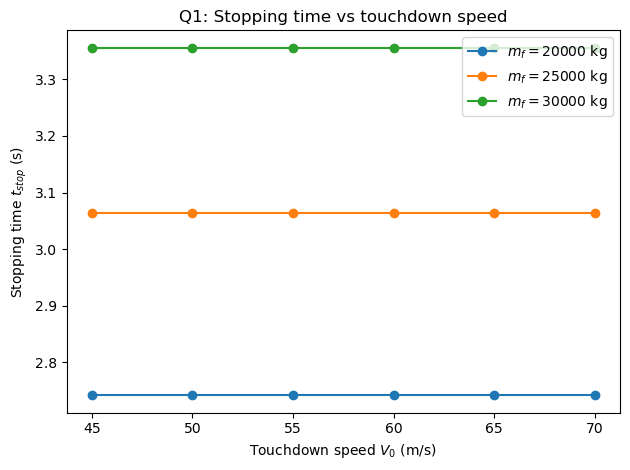

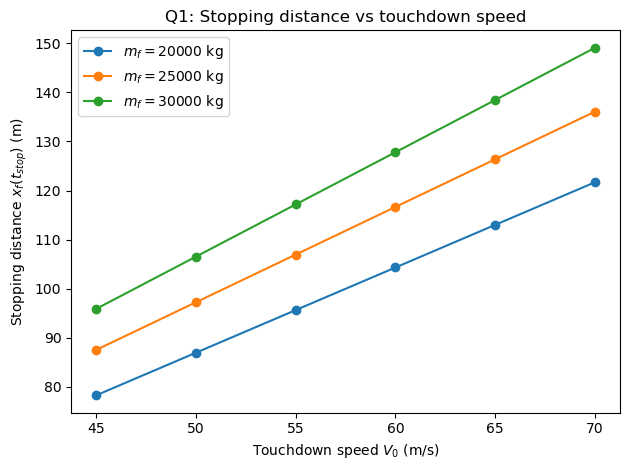

In [24]:
def plot_q1_expanded(p_base, V0_list, m_f_list):
    """Q1 plot: stopping time and stopping distance vs touchdown speed V0.

    Generates two plots:
    1) Stopping time t_stop vs V0
    2) Stopping distance x_f(t_stop) vs V0

    Each curve corresponds to a different aircraft mass m_f.

    Parameters
    ----------
    p_base : Params
        Baseline parameter object to copy.
    V0_list : array_like
        Touchdown speeds to simulate.
    m_f_list : array_like
        Aircraft masses to simulate.
    """
    V0_list = np.asarray(V0_list, dtype=float)

    tstop = {m: [] for m in m_f_list}
    xstop = {m: [] for m in m_f_list}

    for m_f in m_f_list:
        for V0 in V0_list:
            # copy parameters
            p = Params(**{
                **p_base.__dict__,
                "m_f": float(m_f),
                "V0": float(V0)
            })

            # run simulation
            x, dx = make_mesh(p.L, p.nx)
            z0 = initial_state(p)
            ts, zs = integrate(rhs, z0, 0.0, p.t_final, p.dt, p, dx)

            n_int = p.nx - 1
            x_f = zs[:, 2*n_int + 0]

            tstop[m_f].append(ts[-1])
            xstop[m_f].append(x_f[-1])

    # ---- Plot stopping time vs V0 ----
    plt.figure()
    for m_f in m_f_list:
        plt.plot(V0_list, tstop[m_f], marker="o", label=f"$m_f={m_f:.0f}$ kg")
    plt.xlabel("Touchdown speed $V_0$ (m/s)")
    plt.ylabel("Stopping time $t_{stop}$ (s)")
    plt.title("Q1: Stopping time vs touchdown speed")
    plt.legend()
    plt.tight_layout()

    # ---- Plot stopping distance vs V0 ----
    plt.figure()
    for m_f in m_f_list:
        plt.plot(V0_list, xstop[m_f], marker="o", label=f"$m_f={m_f:.0f}$ kg")
    plt.xlabel("Touchdown speed $V_0$ (m/s)")
    plt.ylabel("Stopping distance $x_f(t_{stop})$ (m)")
    plt.title("Q1: Stopping distance vs touchdown speed")
    plt.legend()
    plt.tight_layout()


V0_vals = np.linspace(45.0, 70.0, 6)        # m/s
masses  = [20000, 25000, 30000]       # kg

plot_q1_expanded(default_params(), V0_vals, masses)



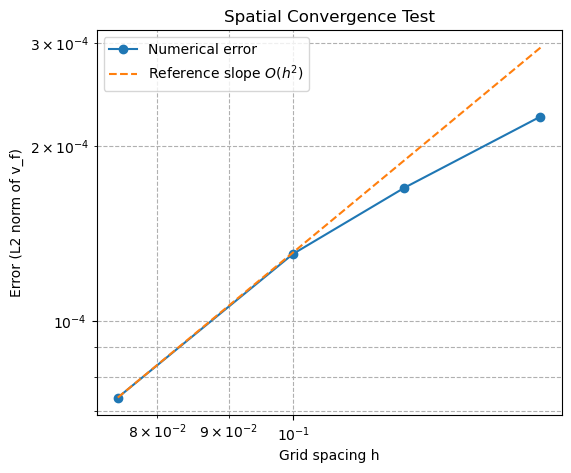

In [ ]:
def spatial_convergence_test(nx_list, p=None, t_final=4.0):
    """
    Perform a spatial convergence test for the arresting-gear simulation.

    Parameters
    ----------
    nx_list : list of int
        List of spatial resolutions (number of intervals) to test.
    p : Params, optional
        Base parameter object. If None, uses default_params().
    t_final : float, optional
        Final time for comparison. If None, uses p.t_final.

    Notes
    -----
    - Uses the finest resolution in nx_list as the reference solution.
    - Error is computed in the L2 norm of the aircraft velocity history.
    - Plots error vs grid spacing with an O(h^2) reference slope.
    """
    if p is None:
        p = default_params()
    if t_final is None:
        t_final = p.t_final

    hs = []
    errors = []
    solutions = {}

    # Run simulations for each nx
    for nx in nx_list:
        p_local = Params(**vars(p))
        p_local.nx = nx
        x, ts, zs = run(p_local)
        solutions[nx] = (x, ts, zs)
        dx = x[1] - x[0]
        hs.append(dx)

    # Use finest nx as reference
    nx_ref = max(nx_list)
    ts_ref, zs_ref = solutions[nx_ref][1], solutions[nx_ref][2]
    n_int_ref = nx_ref - 1
    v_ref = zs_ref[:, 2*n_int_ref + 1]

    # Interpolate reference velocity onto coarser time grids
    for nx in nx_list:
        if nx == nx_ref:
            continue
        ts, zs = solutions[nx][1], solutions[nx][2]
        n_int = nx - 1
        v_f = zs[:, 2*n_int + 1]
        v_ref_interp = np.interp(ts, ts_ref, v_ref)
        error = np.sqrt(np.mean((v_f - v_ref_interp)**2))
        errors.append(error)

    # Remove reference spacing (no error)
    hs = hs[:-1]

    # Plot convergence
    plt.figure(figsize=(6,5))
    plt.loglog(hs, errors, 'o-', label='Numerical error')

    # Reference slope O(h^2)
    h_anchor = hs[-1]
    err_anchor = errors[-1]
    ref_line = err_anchor * (np.array(hs)/h_anchor)**2
    plt.loglog(hs, ref_line, '--', label=r'Reference slope $O(h^2)$')



    plt.xlabel('Grid spacing h')
    plt.ylabel('Error (L2 norm of v_f)')
    plt.title('Spatial Convergence Test')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

nx_test = [400, 500, 600, 800, 1000]
spatial_convergence_test(nx_test)

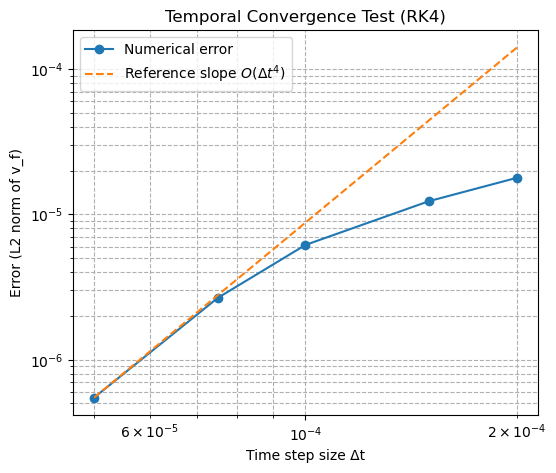

In [30]:
def temporal_convergence_test(dt_list, p=None, nx=None):
    """
    Perform a temporal convergence test for the RK4 integrator.

    Parameters
    ----------
    dt_list : list of float
        List of time step sizes to test.
    p : Params, optional
        Base parameter object. If None, uses default_params().
    nx : int, optional
        Spatial resolution to fix during the test. If None, uses p.nx.

    Notes
    -----
    - Uses the smallest dt in dt_list as the reference solution.
    - Error is computed in the L2 norm of the aircraft velocity history.
    - Plots error vs dt with an O(dt^4) reference slope.
    """
    if p is None:
        p = default_params()
    if nx is not None:
        p.nx = nx

    errors = []
    dts = []
    solutions = {}

    # Run simulations for each dt
    for dt in dt_list:
        p_local = Params(**vars(p))
        p_local.dt = dt
        x, ts, zs = run(p_local)
        solutions[dt] = (ts, zs)
        dts.append(dt)

    # Use smallest dt as reference
    dt_ref = min(dt_list)
    ts_ref, zs_ref = solutions[dt_ref]
    n_int_ref = p.nx - 1
    v_ref = zs_ref[:, 2*n_int_ref + 1]

    # Interpolate reference velocity onto coarser time grids
    for dt in dt_list:
        if dt == dt_ref:
            continue
        ts, zs = solutions[dt]
        n_int = p.nx - 1
        v_f = zs[:, 2*n_int + 1]
        v_ref_interp = np.interp(ts, ts_ref, v_ref)
        error = np.sqrt(np.mean((v_f - v_ref_interp)**2))
        errors.append(error)

    # Remove reference dt (no error)
    dts = dts[:-1]

    # Plot convergence
    plt.figure(figsize=(6,5))
    plt.loglog(dts, errors, 'o-', label='Numerical error')

    # Reference slope O(dt^4), anchored at finest point
    dt_anchor = dts[-1]
    err_anchor = errors[-1]
    ref_line = err_anchor * (np.array(dts)/dt_anchor)**4
    plt.loglog(dts, ref_line, '--', label=r'Reference slope $O(\Delta t^4)$')

    plt.xlabel('Time step size Δt')
    plt.ylabel('Error (L2 norm of v_f)')
    plt.title('Temporal Convergence Test (RK4)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

dt_test = [2.0e-4, 1.5e-4, 1.0e-4, 7.5e-5, 5.0e-5, 2.5e-5]
temporal_convergence_test(dt_test, nx=400)